# Comparing Seagull and Bat Flight Performance in Potential Flow at Different Angles of Attack

In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
import math
import os
%matplotlib inline

## Wing Geometry and Flight Speed

The airfoil used for the seagull wing is S1223, since it is the closest match the the actual geometry of a seagull wing as indicated by Liu, et. al. It was generated in XFOIL and the coordinates recorded below. The actual seagull wing and the S1223 airfoil have similarly shaped pressure distributions, except for the S1223 having a lower pressure on its upper surface compared to the seagull wing. Additionally, there is a slight difference in the thickness distribution, but the maximum thickness and maximum camber positions are the same.

The bat geometry was designed based on "Bat wing airfoil and planform structures relating to aerodynamic cleanliness." The specific bat species chosen is the Western Broad-nosed Bat, native to Australia. It has a sharp leading edge, with maximum camber of about 7% located at about 30% of the chord. The thickness was chosen based on optimal bat flight  performance, less than 0.3% of the chord. The airfoil was generated as such in XFOIL and the coordinates recorded below. 

Flight speed was chosen as 7.6 $m/s$ as an average soaring flight speed of the two birds (bats at roughly 8.6 $m/s$ and seagulls at roughly 6.3 $m/s$)

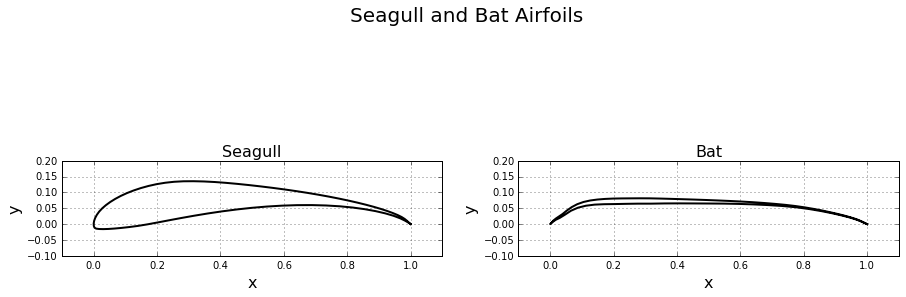

In [2]:
# import geometry for each and plot to check
x_gull = np.array([1.00000, .99838, .99417, .98825, .98075, .97111, .95884, .94389, .92639, .90641, .88406, .85947, .83277, .80412, .77369, .74166, .70823, .67360, .63798, .60158, .56465, .52744, .49025, .45340, .41721, .38193, .34777, .31488, .28347, .25370, .22541, .19846, .17286, .14863, .12591, .10482, .08545, .06789, .05223, .03855, .02694, .01755, .01028, .00495, .00155, .00005, .00044, .00264, .00789, .01718, .03006, .04627, .06561, .08787, .11282, .14020, .17006, .20278, .23840, .27673, .31750, .36044, .40519, .45139, .49860, .54639, .59428, .64176, .68832, .73344, .77660, .81729, .85500, .88928, .91966, .94573, .96693, .98255, .99268, .99825, 1.00000])
y_gull = np.array([0.00000, .00126, .00494, .01037, .01646, .02250, .02853, .03476, .04116, .04768, .05427, .06089, .06749, .07402, .08044, .08671, .09277, .09859, .10412, .10935, .11425, .11881, .12303, .12683, .13011, .13271, .13447, .13526, .13505, .13346, .13037, .12594, .12026, .11355, .10598, .09770, .08879, .07940, .06965, .05968, .04966, .03961, .02954, .01969, .01033, .00178, -.00561, -.01120, -.01427, -.01550, -.01584, -.01532, -.01404, -.01202, -.00925, -.00563, -.00075, .00535, .01213, .01928, .02652, .03358, .04021, .04618, .05129, .05534, .05820, .05976, .05994, .05872, .05612, .05219, .04706, .04088, .03387, .02624, .01822, .01060, .00468, .00115, 0.00000])

x_bat = np.array([1.00000,.99838,.99417,.98825,.98075,.97111,.95884,.94389,.92639,.90640,.88405,.85946,.83276,.80411,.77368,.74165,.70822,.67359,.63797,.60157,.56464,.52743,.49024,.45339,.41720,.38192,.34776,.31487,.28346,.25369,.22540,.19845,.17285,.14862,.12590,.10481,.08544,.06788,.05222,.03854,.02693,.01754,.01027,.00495,.00155,.00005,.00044,.00264,.00789,.01717,.03004,.04625,.06559,.08785,.11280,.14018,.17004,.20276,.23838,.27671,.31748,.36042,.40517,.45137,.49858,.54637,.59426,.64174,.68831,.73343,.77659,.81728,.85499,.88927,.91965,.94573,.96693,.98255,.99268,.99825,1.00000])
y_bat = np.array([-.00035,.00043,.00248,.00543,.00910,.01331,.01770,.02225,.02709,.03206,.03718,.04251,.04765,.05253,.05697,.06070,.06384,.06663,.06912,.07119,.07301,.07462,.07608,.07736,.07848,.07954,.08051,.08122,.08137,.08120,.08098,.08051,.07939,.07745,.07442,.06969,.06283,.05360,.04255,.03149,.02363,.01729,.01128,.00514,.00172,-.00012,.00021,.00251,.00696,.01336,.01953,.02950,.04215,.05187,.05799,.06142,.06273,.06316,.06389,.06447,.06447,.06515,.06536,.06517,.06492,.06460,.06369,.06210,.05992,.05699,.05291,.04741,.04102,.03418,.02726,.02053,.01384,.00758,.00290,.00046,-.00027])

# plot
plt.figure(figsize=(15,6))
plt.suptitle('Seagull and Bat Airfoils', fontsize=20)
                 
plt.subplot(121)                 
plt.grid()
plt.title('Seagull', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
plt.plot(x_gull, y_gull, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.2)
          
plt.subplot(122)                 
plt.grid()
plt.title('Bat', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
plt.plot(x_bat, y_bat, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.2);

In [3]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point
        ya: float
            y-coordinate of the first end-point
        xb: float
            x-coordinate of the second end-point
        yb: float
            y-coordinate of the second end-point
        """
        self.xa, self.ya = xa, ya     # panel starting point
        self.xb, self.yb = xb, yb     # panel end point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # panel center
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)  # panel length
        
        # orientation of the panel
        if xb-xa <= 0.0:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = math.pi + np.arccos(-(yb-ya)/self.length)
            
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'    # upper surface
        else:
            self.loc = 'lower'    # lower surface
        
        self.sigma = 0.0     # source strength
        self.vt = 0.0        # tangential velocity
        self.cp = 0.0        # coefficient of pressure

In [4]:
def define_panels(x, y, N=150):
    """
    Discretizes the geometry into panels_gull using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D numpy array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        150.
        
    Returns
    -------
    panels_gull: 1D numpy array of Panel objects
        The list of panels_gull.
    """
    R = (x.max()-x.min())/2                            # radius of the circle
    x_center = (x.max()+x.min())/2                     # x-coordinate of the circle center
    
    theta = np.linspace(0, 2*np.pi, N+1)             # array of angles
    x_circle = x_center + R*np.cos(theta)              # x-coordinates of the circle
    
    x_ends = np.copy(x_circle)                           # x-coordinate of the panels_gull end-points
    y_ends = np.empty_like(x_ends)                     # y-coordinate of the panels_gull end-points
    
    # extend coordinates to consider closed surface
    x, y = np.append(x, x[0]), np.append(y, y[0])
    
    # compute y-coordinate of the end-points by projection
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels_gull
    panels = np.empty(N, dtype = object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

## Discretize the Wings

In [5]:
panels_gull = define_panels(x_gull, y_gull, N=150)
panels_bat = define_panels(x_bat, y_bat, N=40)

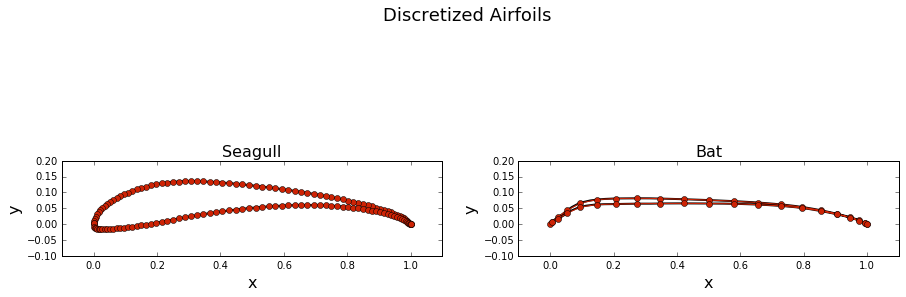

In [6]:
# plot with panels
plt.figure(figsize=(15,6))
plt.suptitle('Discretized Airfoils', fontsize=18)

plt.subplot(121)
plt.title('Seagull', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_gull, y_gull, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels_gull], panels_gull[0].xa),
         np.append([panel.ya for panel in panels_gull], panels_gull[0].ya),
         linestyle='-', linewidth=1, color='#CD2305', marker='o', markersize=6)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.2)

plt.subplot(122)
plt.title('Bat', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_bat, y_bat, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels_bat], panels_bat[0].xa),
         np.append([panel.ya for panel in panels_bat], panels_bat[0].ya),
         linestyle='-', linewidth=1, color='#CD2305', marker='o', markersize=6)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.2);

Note on the number of panels for the bat wing: 40 panels were chosen due to the thinness and overall shape of the bat wing. If a large number of panels were used, the panel method failed.

## $AoA=0$

In [7]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=7.6, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*np.pi/180.0  # degrees to radians

In [8]:
# create freestream conditions
freestream = Freestream(u_inf=7.6, alpha=0.0)

In [9]:
# panel method integral
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - np.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + np.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - np.sin(panel.beta)*s))**2
                   +(y - (panel.ya + np.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

### Build and Solve Linear Equation for Seagull

In [10]:
# source contribution matrix - input panels_gull or bat
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels for the seagull or bat.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                np.cos(panel_i.beta),
                                                np.sin(panel_i.beta))
    return A

In [11]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels for the seagull or bat.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.sin(panel_i.beta),
                                                 -np.cos(panel_i.beta))
    return A

In [12]:
# create source and vortex matrix for seagull and bat
A_source = source_contribution_normal(panels_gull)
B_vortex = vortex_contribution_normal(panels_gull)

/home/gil/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [13]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = np.empty(A_source.shape[0]+1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :])
    return b

In [14]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = np.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [15]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels for the seagull or bat.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels[0].beta)
                               +np.sin(freestream.alpha-panels[-1].beta) )
    return b

In [16]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_gull, freestream)

In [17]:
# solve for singularity strengths for seagulll
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_gull):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [18]:
# solve for singularity strengths for bat
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [19]:
print(gamma)

2.83378415761


In [20]:
def compute_tangential_velocity_gull(panels_gull, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels for seagull.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels_gull.size, panels_gull.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels_gull])
    
    strengths = np.append([panel.sigma for panel in panels_gull], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_gull):
        panel.vt = tangential_velocities[i]

In [21]:
compute_tangential_velocity_gull(panels_gull, freestream, gamma, A_source, B_vortex)

In [22]:
def compute_pressure_coefficient_gull(panels_gull, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels for seagull.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels_gull:
        panel.cp_gull = 1.0 - (panel.vt/freestream.u_inf)**2

In [23]:
compute_pressure_coefficient_gull(panels_gull, freestream)

### $C_L$ Calculation and Accuracy Check

In [24]:
c = abs(max(panel.xa for panel in panels_gull)
        - min(panel.xa for panel in panels_gull))
cl_gull_0 = (gamma*sum(panel.length for panel in panels_gull)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=0: CL_gull_0 = {:0.3f}'.format(cl_gull_0))

lift coefficient at AoA=0: CL_gull_0 = 1.566


In [25]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_gull])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.000900


### Build and Solve Matrix Equation for Bat

In [26]:
def source_contribution_normal(panels_bat):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels_bat: 1D array of Panel objects
        List of panels for the bat.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = np.empty((panels_bat.size, panels_bat.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels_bat):
        for j, panel_j in enumerate(panels_bat):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                np.cos(panel_i.beta),
                                                np.sin(panel_i.beta))
    return A

In [27]:
def vortex_contribution_normal(panels_bat):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels_bat: 1D array of Panel objects
        List of panels for the bat.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.empty((panels_bat.size, panels_bat.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels_bat):
        for j, panel_j in enumerate(panels_bat):
            if i != j:
                A[i, j] = -0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.sin(panel_i.beta),
                                                 -np.cos(panel_i.beta))
    return A

In [28]:
def build_freestream_rhs(panels_bat, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels_bat: 1D array of Panel objects
        List of panels for the bat.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels_bat.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels_bat):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels_bat[0].beta)
                               +np.sin(freestream.alpha-panels_bat[-1].beta) )
    return b

In [29]:
A_source = source_contribution_normal(panels_bat)
B_vortex = vortex_contribution_normal(panels_bat)

In [30]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_bat, freestream)

In [31]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [32]:
print(gamma)

2.19503303533


In [33]:
def compute_tangential_velocity_bat(panels_bat, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels_bat.size, panels_bat.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*np.sin([freestream.alpha-panel.beta 
                                    for panel in panels_bat])
    
    strengths = np.append([panel.sigma for panel in panels_bat], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels_bat):
        panel.vt = tangential_velocities[i]

In [34]:
compute_tangential_velocity_bat(panels_bat, freestream, gamma, A_source, B_vortex)

In [35]:
def compute_pressure_coefficient_bat(panels_bat, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels_gull: 1D array of Panel objects
        List of panels_gull.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels_bat:
        panel.cp_bat = 1.0 - (panel.vt/freestream.u_inf)**2

In [36]:
compute_pressure_coefficient_bat(panels_bat, freestream)

### $C_L$ and Accuracy Check

In [37]:
c = abs(max(panel.xa for panel in panels_bat)
        - min(panel.xa for panel in panels_bat))
cl_bat_0 = (gamma*sum(panel.length for panel in panels_bat)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=0: CL_bat_0 = {:0.3f}'.format(cl_bat_0))

lift coefficient at AoA=0: CL_bat_0 = 1.187


In [38]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_bat])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.174471


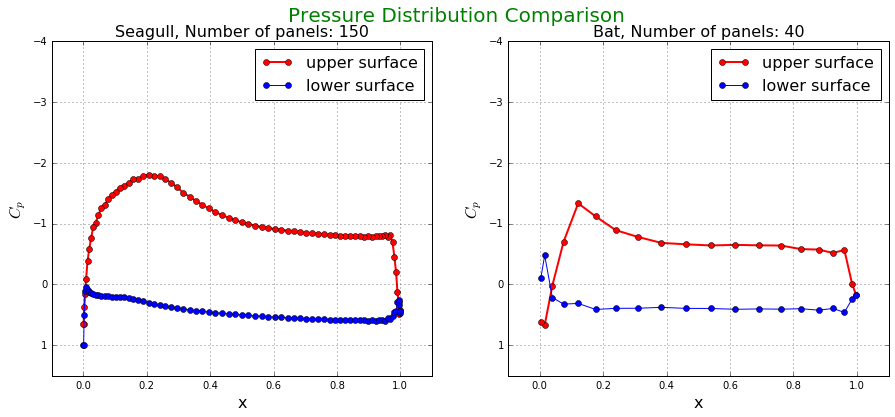

In [39]:
# plot both
plt.figure(figsize=(15,6))
plt.suptitle('Pressure Distribution Comparison', fontsize=20, color='green')

plt.subplot(121)
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='upper'],
         [panel.cp_gull for panel in panels_gull if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='lower'],
         [panel.cp_gull for panel in panels_gull if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.5, -4.0)
plt.title('Seagull, Number of panels: {}'.format(panels_gull.size), fontsize=16);

plt.subplot(122)
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='upper'],
         [panel.cp_bat for panel in panels_bat if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='lower'],
         [panel.cp_bat for panel in panels_bat if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.5, -4.0)
plt.title('Bat, Number of panels: {}'.format(panels_bat.size), fontsize=16);

The Pressure Distribution Comparison for $AoA=0$ shows the seagull and bat wings having roughly the same pressure values on the lower surface of the wing, with the seagull having a slightly lower pressure value on the upper surface (and thus likely generating more lift). The discrepancy in the bat wing distribution is likely due to the sharp leading edge of the bat wing.

# $AoA=5$

In [40]:
# new freestream conditions and freestream RHS
freestream = Freestream(u_inf=7.6, alpha=5.0)

### Redefine Matrices and Solve for Seagull

In [41]:
A_source = source_contribution_normal(panels_gull)
B_vortex = vortex_contribution_normal(panels_gull)

/home/gil/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [42]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_gull, freestream)

In [43]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [44]:
print(gamma)

3.87626127411


In [45]:
compute_tangential_velocity_gull(panels_gull, freestream, gamma, A_source, B_vortex)

In [46]:
compute_pressure_coefficient_gull(panels_gull, freestream)

### $C_L$ and Accuracy Check

In [47]:
c = abs(max(panel.xa for panel in panels_gull)
        - min(panel.xa for panel in panels_gull))
cl_gull_5 = (gamma*sum(panel.length for panel in panels_gull)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=5: CL_gull_5 = {:0.3f}'.format(cl_gull_5))

lift coefficient at AoA=5: CL_gull_5 = 2.141


In [48]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_gull])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.000900


### Redefine Matrices and Solve for Bat

In [49]:
A_source = source_contribution_normal(panels_bat)
B_vortex = vortex_contribution_normal(panels_bat)

In [50]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_bat, freestream)

In [51]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [52]:
print(gamma)

3.1883699592


In [53]:
compute_tangential_velocity_bat(panels_bat, freestream, gamma, A_source, B_vortex)

In [54]:
compute_pressure_coefficient_bat(panels_bat, freestream)

### $C_L$ and Accuracy Check

In [55]:
c = abs(max(panel.xa for panel in panels_bat)
        - min(panel.xa for panel in panels_bat))
cl_bat_5 = (gamma*sum(panel.length for panel in panels_bat)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=5: CL_bat_5 = {:0.3f}'.format(cl_bat_5))

lift coefficient at AoA=5: CL_bat_5 = 1.724


In [56]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_bat])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: -0.461868


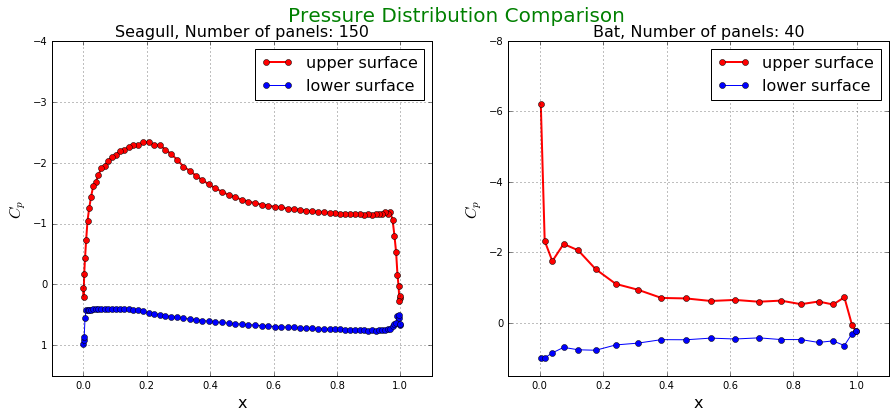

In [57]:
# plot both pressure distributions
plt.figure(figsize=(15,6))
plt.suptitle('Pressure Distribution Comparison', fontsize=20, color='green')

plt.subplot(121)
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='upper'],
         [panel.cp_gull for panel in panels_gull if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='lower'],
         [panel.cp_gull for panel in panels_gull if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.5, -4.0)
plt.title('Seagull, Number of panels: {}'.format(panels_gull.size), fontsize=16)

plt.subplot(122)
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='upper'],
         [panel.cp_bat for panel in panels_bat if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='lower'],
         [panel.cp_bat for panel in panels_bat if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.5, -8.0)
plt.title('Bat, Number of panels: {}'.format(panels_bat.size), fontsize=16);

For $AoA=5$ shown here, one can note that the discrepancy in the bat wing distribution has disappeared. The increased $AoA$ has likely created an effective situation similar to a standard cambered airfoil in a zero $AoA$ flow.

Further, the seagull wing has a greater pressure on the lower surface and lower pressure on the upper surface, generating more lift, despite the lower pressure at the leading edge of the bat wing. 

# $AoA=10$

In [58]:
# new freestream conditions and freestream RHS
freestream = Freestream(u_inf=7.6, alpha=10.0)

### Redefine Matrices and Solve for Seagull

In [59]:
A_source = source_contribution_normal(panels_gull)
B_vortex = vortex_contribution_normal(panels_gull)

/home/gil/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [60]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_gull, freestream)

In [61]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [62]:
print(gamma)

4.88923770176


In [63]:
compute_tangential_velocity_gull(panels_gull, freestream, gamma, A_source, B_vortex)

In [64]:
compute_pressure_coefficient_gull(panels_gull, freestream)

### $C_L$ and Accuracy Check

In [65]:
c = abs(max(panel.xa for panel in panels_gull)
        - min(panel.xa for panel in panels_gull))
cl_gull_10 = (gamma*sum(panel.length for panel in panels_gull)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=10: CL_gull_10 = {:0.3f}'.format(cl_gull_10))

lift coefficient at AoA=10: CL_gull_10 = 2.701


In [66]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_gull])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.000900


### Redefine Matrices and Solve for Bat

In [67]:
A_source = source_contribution_normal(panels_bat)
B_vortex = vortex_contribution_normal(panels_bat)

In [68]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_bat, freestream)

In [69]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [70]:
print(gamma)

4.1574414625


In [71]:
compute_tangential_velocity_bat(panels_bat, freestream, gamma, A_source, B_vortex)

In [72]:
compute_pressure_coefficient_bat(panels_bat, freestream)

### $C_L$ and Accuracy Check

In [73]:
c = abs(max(panel.xa for panel in panels_bat)
        - min(panel.xa for panel in panels_bat))
cl_bat_10 = (gamma*sum(panel.length for panel in panels_bat)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=10: CL_bat_10 = {:0.3f}'.format(cl_bat_10))

lift coefficient at AoA=10: CL_bat_10 = 2.248


In [74]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_bat])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: -1.094692


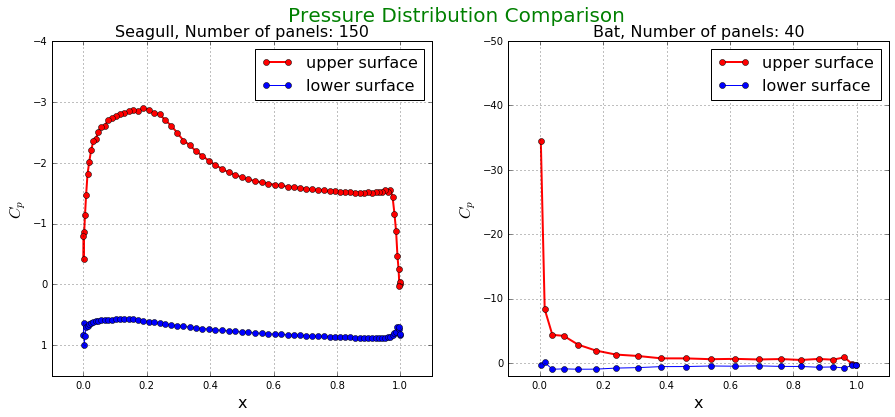

In [75]:
# plot both pressure distributions
plt.figure(figsize=(15,6))
plt.suptitle('Pressure Distribution Comparison', fontsize=20, color='green')

plt.subplot(121)
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='upper'],
         [panel.cp_gull for panel in panels_gull if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='lower'],
         [panel.cp_gull for panel in panels_gull if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.5, -4.0)
plt.title('Seagull, Number of panels: {}'.format(panels_gull.size), fontsize=16)

plt.subplot(122)
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='upper'],
         [panel.cp_bat for panel in panels_bat if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='lower'],
         [panel.cp_bat for panel in panels_bat if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(2.0, -50.0)
plt.title('Bat, Number of panels: {}'.format(panels_bat.size), fontsize=16);

As expected, the higher $AoA$ yields similar results to an increased degree

# $AoA=15$

In [76]:
# new freestream conditions and freestream RHS
freestream = Freestream(u_inf=7.6, alpha=15.0)

### Redefine Matrices and Solve for Seagull

In [77]:
A_source = source_contribution_normal(panels_gull)
B_vortex = vortex_contribution_normal(panels_gull)

/home/gil/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [78]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_gull, freestream)

In [79]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [80]:
print(gamma)

5.86500407829


In [81]:
compute_tangential_velocity_gull(panels_gull, freestream, gamma, A_source, B_vortex)

In [82]:
compute_pressure_coefficient_gull(panels_gull, freestream)

### $C_L$ and Accuracy Check

In [83]:
c = abs(max(panel.xa for panel in panels_gull)
        - min(panel.xa for panel in panels_gull))
cl_gull_15 = (gamma*sum(panel.length for panel in panels_gull)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=15: CL_gull_15 = {:0.3f}'.format(cl_gull_15))

lift coefficient at AoA=15: CL_gull_15 = 3.240


In [84]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_gull])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.000900


### Redefine Matrices and Solve for Bat

In [85]:
A_source = source_contribution_normal(panels_bat)
B_vortex = vortex_contribution_normal(panels_bat)

In [86]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_bat, freestream)

In [87]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [88]:
print(gamma)

5.09487232593


In [89]:
compute_tangential_velocity_bat(panels_bat, freestream, gamma, A_source, B_vortex)

In [90]:
compute_pressure_coefficient_bat(panels_bat, freestream)

### $C_L$ and Accuracy Check

In [91]:
c = abs(max(panel.xa for panel in panels_bat)
        - min(panel.xa for panel in panels_bat))
cl_bat_15 = (gamma*sum(panel.length for panel in panels_bat)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=15: CL_bat_15 = {:0.3f}'.format(cl_bat_15))

lift coefficient at AoA=15: CL_bat_15 = 2.754


In [92]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_bat])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: -1.719185


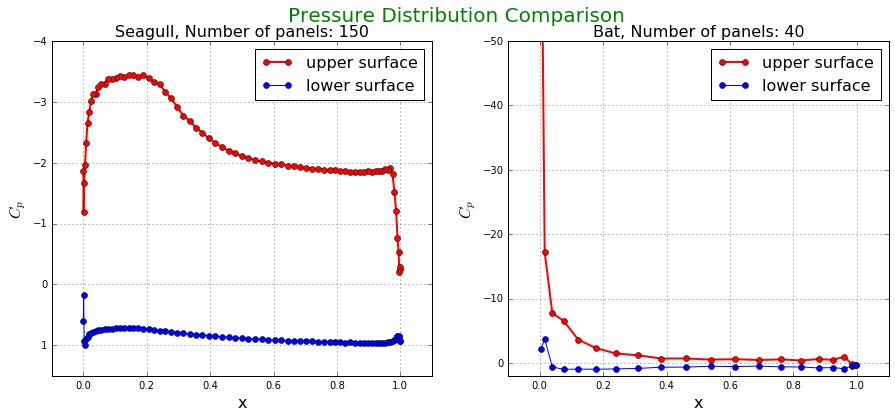

In [93]:
# plot both pressure distributions
plt.figure(figsize=(15,6))
plt.suptitle('Pressure Distribution Comparison', fontsize=20, color='green')

plt.subplot(121)
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='upper'],
         [panel.cp_gull for panel in panels_gull if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='lower'],
         [panel.cp_gull for panel in panels_gull if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.5, -4.0)
plt.title('Seagull, Number of panels: {}'.format(panels_gull.size), fontsize=16)

plt.subplot(122)
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='upper'],
         [panel.cp_bat for panel in panels_bat if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='lower'],
         [panel.cp_bat for panel in panels_bat if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(2.0, -50.0)
plt.title('Bat, Number of panels: {}'.format(panels_bat.size), fontsize=16);

# $AoA=20$

In [94]:
# new freestream conditions and freestream RHS
freestream = Freestream(u_inf=7.6, alpha=20.0)

### Redefine Matrices and Solve for Seagull

In [95]:
A_source = source_contribution_normal(panels_gull)
B_vortex = vortex_contribution_normal(panels_gull)

/home/gil/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [96]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_gull, freestream)

In [97]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [98]:
print(gamma)

6.79613423241


In [99]:
compute_tangential_velocity_gull(panels_gull, freestream, gamma, A_source, B_vortex)

In [100]:
compute_pressure_coefficient_gull(panels_gull, freestream)

### $C_L$ and Accuracy Check

In [101]:
c = abs(max(panel.xa for panel in panels_gull)
        - min(panel.xa for panel in panels_gull))
cl_gull_20 = (gamma*sum(panel.length for panel in panels_gull)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=20: CL_gull_20 = {:0.3f}'.format(cl_gull_20))

lift coefficient at AoA=20: CL_gull_20 = 3.755


In [102]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_gull])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.000900


### Redefine Matrices and Solve for Bat

In [103]:
A_source = source_contribution_normal(panels_bat)
B_vortex = vortex_contribution_normal(panels_bat)

In [104]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_bat, freestream)

In [105]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i, panel in enumerate(panels_bat):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [106]:
print(gamma)

5.9935281346


In [107]:
compute_tangential_velocity_bat(panels_bat, freestream, gamma, A_source, B_vortex)

In [108]:
compute_pressure_coefficient_bat(panels_bat, freestream)

### $C_L$ and Accuracy Check

In [109]:
c = abs(max(panel.xa for panel in panels_bat)
        - min(panel.xa for panel in panels_bat))
cl_bat_20 = (gamma*sum(panel.length for panel in panels_bat)
      / (0.5*freestream.u_inf*c))
print('lift coefficient at AoA=20: CL_bat_20 = {:0.3f}'.format(cl_bat_20))

lift coefficient at AoA=20: CL_bat_20 = 3.240


In [110]:
# calculate the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels_bat])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: -2.330594


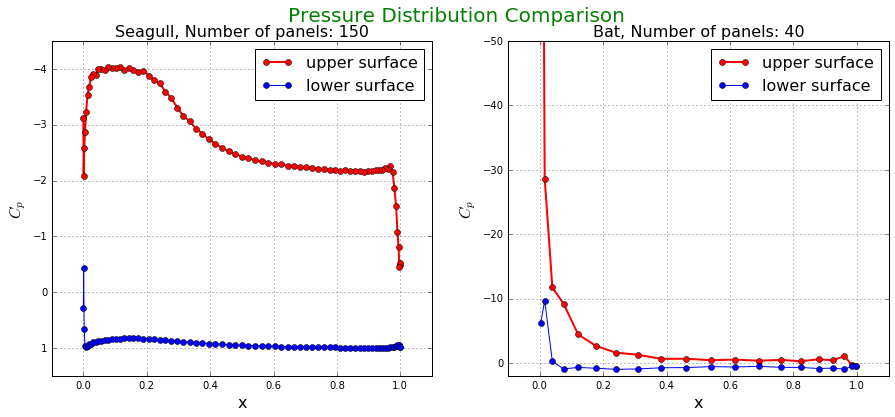

In [111]:
# plot both pressure distributions
plt.figure(figsize=(15,6))
plt.suptitle('Pressure Distribution Comparison', fontsize=20, color='green')

plt.subplot(121)
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='upper'],
         [panel.cp_gull for panel in panels_gull if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_gull if panel.loc=='lower'],
         [panel.cp_gull for panel in panels_gull if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(1.5, -4.5)
plt.title('Seagull, Number of panels: {}'.format(panels_gull.size), fontsize=16)

plt.subplot(122)
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='upper'],
         [panel.cp_bat for panel in panels_bat if panel.loc=='upper'],
         label='upper surface', color='r', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot([panel.xc for panel in panels_bat if panel.loc=='lower'],
         [panel.cp_bat for panel in panels_bat if panel.loc=='lower'],
         label='lower surface', color='blue', linewidth=1, linestyle='-', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-0.1, 1.1)
plt.ylim(2.0, -50.0)
plt.title('Bat, Number of panels: {}'.format(panels_bat.size), fontsize=16);

# Plot $C_L$ vs. $\alpha$ 

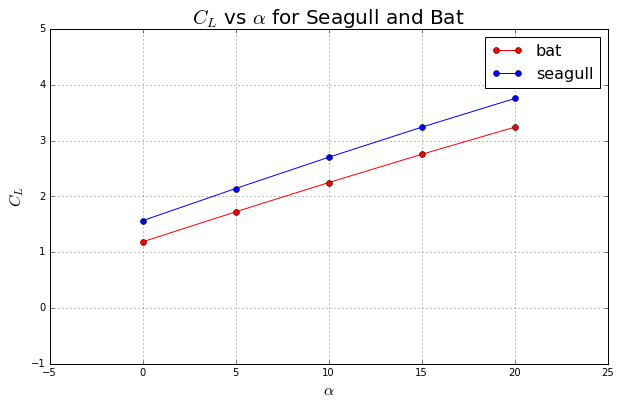

In [112]:
# create arrays and plot
AoA = np.array([0.0, 5.0, 10.0, 15.0, 20.0])
CL_gull = np.array([cl_gull_0, cl_gull_5, cl_gull_10, cl_gull_15, cl_gull_20])
CL_bat = np.array([cl_bat_0, cl_bat_5, cl_bat_10, cl_bat_15, cl_bat_20])

plt.figure(figsize=(10,6))
plt.grid()
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel('$C_L$', fontsize=16)
plt.xlim(-5.0, 25)
plt.ylim(-1.0, 5.0)
plt.title(r'$C_L$ vs $\alpha$ for Seagull and Bat', fontsize=20)
plt.plot(AoA, CL_bat, linestyle='-', color='r', label='bat', marker='o', markersize=6)
plt.plot(AoA, CL_gull, linestyle='-', color='b', label='seagull', marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16});

The above compares the Lift Coefficients of each animal. The difference in $C_L$ could be due to flight height off the ground, or to the panel method's approximation for the bat wing. The bat used for this study is a foraging bat, so it remains relatively close to the ground when flying, elminating the need for an extremely high lift wing.

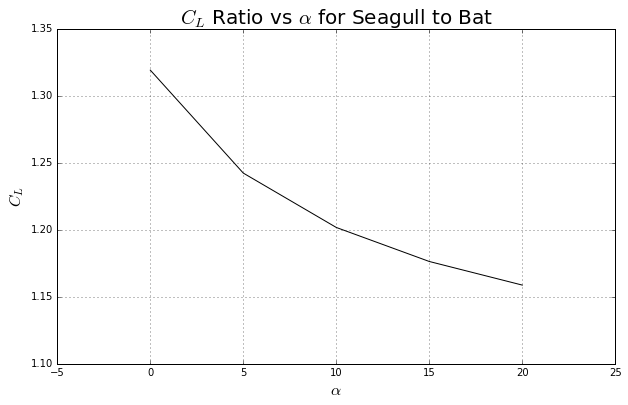

In [113]:
CL_ratio = CL_gull/CL_bat

plt.figure(figsize=(10,6))
plt.grid()
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel('$C_L$', fontsize=16)
plt.xlim(-5.0, 25)
plt.ylim(1.1, 1.35)
plt.title(r'$C_L$ Ratio vs $\alpha$ for Seagull to Bat', fontsize=20)
plt.plot(AoA, CL_ratio, linestyle='-', color='k');

The above shows the ratio of seagull $C_L$ to bat $C_L$, which appear to be converging to some value. Potential flow cannot predict a maximum $C_L$, though, so it is unclear if increasing $AoA$ would lead to convergence in actual flight.

# Limitations and Conclusions

This study was done assuming potential flow and rigid animal wings during soaring flight. In reality, the flapping process is very complicated, and of course helps to increase lift for each animal. Here, I do not account for flapping since that would require a much more in-depth analysis beyond the scope of potential flow. Potential flow also cannot account for a maximum $C_L$, so the analysis here is unable to find the $AoA$ at which that occurs.

Further, the sharp leading edge and overall shape of the bat wing may present problems for the panel method. Attempting to use a greater number of panels resulted in an unsatisfied Kutta condition (with $\gamma=nan$) or a very negative lift, which in reality is not the case. Additionally, the accuracy checks for the bat wing did not equal 0 and got worse with increasing $AoA$. This may again be due to the panel method implemented on the particular shape of the bat wing. Therefore, the panel method may not be ideal in examining wings or airfoils with sharp leading edges and very low thickness.

For future studies, a model that accounts for viscous flow and flapping would be significantly more accurate in predicting actual flight dynamics of the animals. A method that would account for sharp leading edges and low thickness would also enhance the accuracy. However, this is at least a start for a low $AoA$ in examining how the flight preformance of the two animals compare.

# References

Hoey, R. G. (1992). Research on the stability and control of soaring birds. AIAA Paper No. AIAA-1992-4122.

Bullen, R. D., & McKenzie, N. L. (2007). Bat wing airfoil and planform structures relating to aerodynamic cleanliness. Australian Journal of Zoology, 55(4), 237-247.

Liu, T., Kuykendoll, K., Rhew, R., & Jones, S. (2006). Avian wing geometry and kinematics. AIAA journal, 44(5), 954-963.